In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
x_data = np.linspace(0.0, 10.0, 1000000)
noise = np.random.randn(len(x_data))

I am gonna model my line as y = mx + b

b = 5

Also add some noise to it

In [3]:
y_true = (0.5 * x_data) + 5 + noise

Using pandas DF

In [4]:
x_df = pd.DataFrame(data=x_data, columns=['X_Data'])
y_df = pd.DataFrame(data=y_true, columns=['Y'])

In [5]:
x_df.head()

,X_Data
0,0.00000
1,0.00001
2,0.00002
3,0.00003
4,0.00004


In [6]:
y_df.head()

,Y
0,3.278798
1,4.910461
2,4.798022
3,3.942988
4,6.482172


In [9]:
my_data = pd.concat([x_df, y_df], axis=1) # To concatenate along the columns
my_data.head()

,X_Data,Y
0,0.00000,3.278798
1,0.00001,4.910461
2,0.00002,4.798022
3,0.00003,3.942988
4,0.00004,6.482172


Now lets plot a sample of it as plotting the whole thing might make the kernel to crash

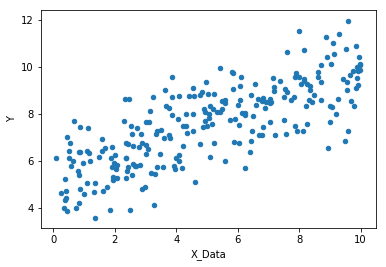

In [13]:
sample_data = my_data.sample(n=250) # This returns 250 random samples
sample_data.plot(kind='scatter', x='X_Data', y='Y');

## Regression without the Estimator API

Make a tensorflow regressor

A million points is too much so make batches of data

In [20]:
batch_size = 8
randomSlopeAndIntercept = np.random.randn(2)

# Create Variables
m = tf.Variable(randomSlopeAndIntercept[0]) # slope
b = tf.Variable(randomSlopeAndIntercept[1]) # intercept

# Create Placeholders
xph = tf.placeholder(tf.float64, [batch_size])
yph = tf.placeholder(tf.float64, [batch_size])

# Define our Graph
# ie the actual operation that takes place
y_model = m*xph + b

# Define the cost function
# error = 0
# # cumulate the error
# for x, y in zip(x_data, y_label):
#     y_hat = m*x+b
#     error += (y - y_hat)**2
error = tf.reduce_sum(tf.square(yph - y_model)) # instead of the above code, do this

# Make the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

# Create init variable
init = tf.global_variables_initializer()

In [35]:
# Making a session and run it
with tf.Session() as sess:
    # initialize variables
    sess.run(init)
    # we just need 8 * 1000 data points, no need to feed it all
    batches = 1000
    for i in range(batches):
        # Grab 8 random indexes from the data
        rand_index = np.random.randint(len(x_data), size=batch_size)
        # feed only those points to the placeholders
        feed = {xph:x_data[rand_index], yph:y_true[rand_index]}
        # train on those points
        sess.run(train, feed_dict=feed)
    # Grab the estimated slope and intercept
    model_m, model_b = sess.run([m, b])

In [36]:
model_m

0.5278523040219406

In [37]:
model_b

4.861583728757572

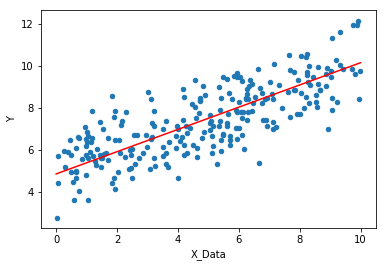

In [38]:
# Visualizing
y_hat = x_data*model_m + model_b
my_data.sample(250).plot(kind='scatter', x='X_Data', y='Y')
plt.plot(x_data, y_hat,'r');

## The Estimator API of TensorFlow

To use the Estimator API, do the following

1. Define a list of feature columns

2. Create the estimator model

3. Create a data input function

4. Call train, evaluate(test) and predict(unknown label) on the estimator object

In [39]:
# Create feature columns
# It is a numeric col with name x and 1 dimension
feat_cols = [ tf.feature_column.numeric_column('x', shape=[1]) ]

# Creating the estimator object
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp1ju7k867', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3bf8522828>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Doing train test split

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_true, test_size=0.3)
print(x_eval.shape, x_train.shape)

(300000,) (700000,)


In [44]:
# Continuing with the estimator
# Creating an input function
# 'x' here is the name given to the feature_cols when we declared it
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train}, y_train,
                                                batch_size=8, num_epochs=None, shuffle=True)
# shuffle here is set to false so that my evaluation is in order
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train}, y_train,
                                                      batch_size=8, num_epochs=1000,
                                                      shuffle=False)
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval}, y_eval, batch_size=8,
                                                    num_epochs=1000, shuffle=False)

In [45]:
# Train the estimator
# Note for input_func, we did not mentioin the no of epochs, hence mention that here 
# by using the parameter steps
estimator.train(input_fn=input_func, steps=1000)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp1ju7k867/model.ckpt.
INFO:tensorflow:loss = 459.06024, step = 1
INFO:tensorflow:global_step/sec: 185.128
INFO:tensorflow:loss = 15.427731, step = 101 (0.539 sec)
INFO:tensorflow:global_step/sec: 378.4
INFO:tensorflow:loss = 9.454784, step = 201 (0.264 sec)
INFO:tensorflow:global_step/sec: 353.855
INFO:tensorflow:loss = 19.719164, step = 301 (0.283 sec)
INFO:tensorflow:global_step/sec: 250.547
INFO:tensorflow:

In [46]:
# Evaluate the model on train set
train_metrics = estimator.evaluate(input_fn=train_input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17T07:49:39Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmp1ju7k867/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2019-06-17-07:49:44
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.0982218, global_step = 1000, label/mean = 7.475172, loss = 8.785774, predictio

In [47]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-17T07:50:54Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1ju7k867/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2019-06-17-07:50:57
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.0853766, global_step = 1000, label/mean = 7.5141892, loss = 8.683013, prediction/mean = 7.3365717
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10

In [48]:
print(train_metrics)

{'average_loss': 1.0982218, 'label/mean': 7.475172, 'loss': 8.785774, 'prediction/mean': 7.31697, 'global_step': 1000}


In [50]:
print(eval_metrics)

{'average_loss': 1.0853766, 'label/mean': 7.5141892, 'loss': 8.683013, 'prediction/mean': 7.3365717, 'global_step': 1000}


If the training data loss is low and the test/eval data loss is high, it means that the estimamtor is overfitting. We need the losses to be low and the training and test loss to be close to each other

Predicting the results for new data

In [54]:
# make an input function
# make new unseed data
brand_new_data = np.linspace(0, 10, 10)

# Make input function for new data, there is no y label here
input_func_predict=tf.estimator.inputs.numpy_input_fn({'x':brand_new_data}, shuffle=False)

# predicting output
estimator.predict(input_fn=input_func_predict)

<generator object EstimatorV2.predict at 0x7f3bc6737228>

We get a generator object

To see it, either iterate through it or cast it to a list

In [55]:
list(estimator.predict(input_fn=input_func_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1ju7k867/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.4600797], dtype=float32)},
 {'predictions': array([5.098109], dtype=float32)},
 {'predictions': array([5.736138], dtype=float32)},
 {'predictions': array([6.3741665], dtype=float32)},
 {'predictions': array([7.012196], dtype=float32)},
 {'predictions': array([7.6502247], dtype=float32)},
 {'predictions': array([8.288254], dtype=float32)},
 {'predictions': array([8.926283], dtype=float32)},
 {'predictions': array([9.564312], dtype=float32)},
 {'predictions': array([10.202341], dtype=float32)}]

In [57]:
predictions = []
for pred in estimator.predict(input_fn=input_func_predict):
    predictions.append(pred['predictions'])
predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1ju7k867/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[array([4.4600797], dtype=float32),
 array([5.098109], dtype=float32),
 array([5.736138], dtype=float32),
 array([6.3741665], dtype=float32),
 array([7.012196], dtype=float32),
 array([7.6502247], dtype=float32),
 array([8.288254], dtype=float32),
 array([8.926283], dtype=float32),
 array([9.564312], dtype=float32),
 array([10.202341], dtype=float32)]

In [60]:
predictions[1][0]

5.098109

Plotting the result

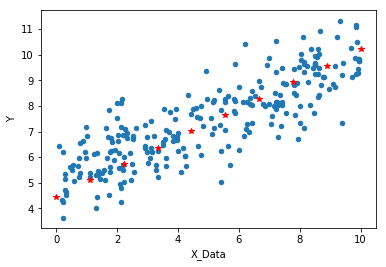

In [64]:
my_data.sample(n=250).plot(kind='scatter', x='X_Data', y='Y')
plt.plot(brand_new_data, predictions, 'r*') # points we predicted